##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Quantum advantage in learning from experiments

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/quantum/tutorials/quantum_advantage_in_learning_from_experiments"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/quantum/blob/master/docs/tutorials/quantum_advantage_in_learning_from_experiments.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/quantum_advantage_in_learning_from_experiments.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/quantum/docs/tutorials/quantum_advantage_in_learning_from_experiments.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows the experiments of <a target="_blank" href="https://arxiv.org/abs/2112.00778" class="external">Quantum advantage in learning from experiments</a>.

## Setup

In [ ]:
!pip install tensorflow==2.4.1

Install TensorFlow Quantum:

In [ ]:
!pip install tensorflow-quantum

In [ ]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

Now import TensorFlow and the module dependencies:

In [25]:
import tensorflow as tf
import cirq
import matplotlib.pyplot as plt
import numpy as np
import sympy

## 1. The Basics

We first define the circuit we are going to use to generate samples

In [26]:
def un_bell_pair_block(qubits):
    return [cirq.CNOT(qubits[0], qubits[1]), cirq.H(qubits[0])]

def inv_z_basis_gate(pauli):
    if pauli == "I" or pauli == "Z":
        return cirq.I
    if pauli == "X":
        return cirq.H
    if pauli == "Y":
        # S^dag H to get to computational, H S to go back.
        return cirq.PhasedXZGate(
            axis_phase_exponent=-0.5, x_exponent=0.5, z_exponent=-0.5
        )
    raise ValueError("Invalid Pauli.")
    
def build_circuit(
    qubit_pairs,
    pauli,
    n_shots,
    rand_state):
    a_qubits = [pair[0] for pair in qubit_pairs]
    b_qubits = [pair[1] for pair in qubit_pairs]
    all_qubits = np.concatenate(qubit_pairs)

    flip_params = sympy.symbols(f"param_0:{len(qubit_pairs) * 2}")

    # Add X flips.
    ret_circuit = cirq.Circuit(cirq.X(q) ** p for q, p in zip(all_qubits, flip_params))

    # Add basis turns a and b.
    ret_circuit += [
        inv_z_basis_gate(p)(q) for q, p in zip(a_qubits, pauli)
    ]
    ret_circuit += [
        inv_z_basis_gate(p)(q) for q, p in zip(b_qubits, pauli)
    ]

    # Add un-bell pair.
    ret_circuit += [un_bell_pair_block(pair) for pair in qubit_pairs]

    # Add measurements.
    for i, qubit in enumerate(all_qubits):
        ret_circuit += cirq.measure(qubit, key=f"q{i}")

    # Create randomized flippings. These flippings will contain values of 1,0.
    # which will turn the X gates on or off.
    params = create_randomized_sweeps(
        pauli, flip_params, n_shots, rand_state
    )
    return ret_circuit, params



Then, we create the samples.

In [27]:
def create_randomized_sweeps(
    hidden_p,
    symbols,
    n_params,
    rand_state):
    last_i = 0
    for i, pauli in enumerate(hidden_p):
        if pauli != "I":
            last_i = i

    sign_p = rand_state.choice([1, -1])
    all_sweeps = []
    for _ in range(n_params):
        current_sweep = dict()
        for twocopy in [0, 1]:
            parity = sign_p * rand_state.choice([1, -1], p=[0.95, 0.05])
            for i, pauli in enumerate(hidden_p):
                current_symbol = symbols[2 * i + twocopy]
                current_sweep[current_symbol] = rand_state.choice([0, 1])
                if pauli != "I":
                    if last_i == i:
                        v = 1 if parity == -1 else 0
                        current_sweep[current_symbol] = v
                    elif current_sweep[current_symbol] == 1:
                        parity *= -1

        all_sweeps.append(current_sweep)
    return all_sweeps


We run the code

In [63]:
rand_source = np.random.RandomState(20160913)
n_paulis = 2
n = 3
n_shots = 11
n_repeats = 2

system_pairs = [(cirq.GridQubit(0, i), cirq.GridQubit(1, i)) for i in range(n)]
simulator = cirq.Simulator()

all_results = []

for pauli_num in rand_source.choice(range(4 ** n), n_paulis, replace=False):
    pauli = ''
    for _ in range(n):
        base4 = pauli_num % 4
        if base4 == 0:
            pauli += 'I'
        elif base4 == 1:
            pauli += 'X'
        elif base4 == 2:
            pauli += 'Y'
        else:
            pauli += 'Z'
        pauli_num = (pauli_num - base4) // 4

    circuit, sweeps = build_circuit(system_pairs, pauli, n_shots, rand_source)
    
    results_for_pauli = []
    for _ in range(n_repeats):
        results_for_repeat = []
        for b in range(n_shots):
            results = simulator.run_sweep(
                program=circuit,
                params=sweeps[b : b + n_sweeps],
                repetitions=1
            )

            batch_results = []
            for j, single_circuit_samples in enumerate(results):
                qubit_order = [f"q{i}" for i in range(2 * n)]
                out0 = single_circuit_samples.data[qubit_order].to_numpy()
                batch_results.append(np.squeeze(out0))

            batch_results = np.array(batch_results)
            results_for_repeat.append(batch_results)

        results_for_pauli.append(np.concatenate(results_for_repeat))
    all_results.append(results_for_pauli)


We encode the results so that they can be ingested by our neural network.

In [60]:
class InnerLayer(tf.keras.Model):
    def __init__(self, n_shots, n):
        super(InnerLayer, self).__init__(name='')
        self.n_shots = n_shots
        self.n = n
        self.gru1 = tf.keras.layers.GRU(4, go_backwards=False, return_sequences=True)
        self.gru2 = tf.keras.layers.GRU(4, go_backwards=True,  return_sequences=True)
        self.gru3 = tf.keras.layers.GRU(4, go_backwards=False, return_sequences=False)

    def call(self, x):
        x = tf.expand_dims(tf.reshape(x, (-1, 2 * self.n)), -1)
        x = self.gru1(x)
        x = self.gru2(x)
        x = self.gru3(x)
        x = tf.reshape(x, (-1, self.n_shots, 4))
        return x

class IntermediateLayer(tf.keras.Model):
    def __init__(self):
        super(IntermediateLayer, self).__init__(name='')
    
    def build(self, input_shape):
        self.kernel = self.add_weight("kernel", shape=[int(input_shape[2]), 8])
    
    def call(self, x):
        x = tf.math.reduce_mean(x, axis=1)
        x = tf.matmul(x, self.kernel)    
        return x

model = tf.keras.Sequential()
model.add(InnerLayer(n_shots, n))
model.add(IntermediateLayer())

We define the conjoined model

In [61]:
input_1 = tf.keras.Input((n_shots, 2 * n,))
input_2 = tf.keras.Input((n_shots, 2 * n,))

encoded_1 = model(input_1)
encoded_2 = model(input_2)

class OuterLayer(tf.keras.Model):
    def __init__(self):
        super(OuterLayer, self).__init__(name='')
        
    def call(self, x):
        x = tf.norm(x[1] - x[0], ord=2, axis=1)
        x = tf.stack([x, tf.ones(tf.shape(x))], axis=1)
        x = tf.nn.softmax(x)
        return x

predictor = OuterLayer()
prediction = predictor([encoded_1, encoded_2])

conjoined_net = tf.keras.Model(inputs=[input_1, input_2], outputs=prediction)

We train the model

In [72]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

conjoined_net.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

def _sample_different(max_val, ref):
    ret = ref
    while ret == ref:
        ret = rand_source.choice(max_val)
    return ret

x1 = []
x2 = []
y = []
for pauli_idx in range(n_paulis):
    # Same Pauli
    for i in range(n_repeats):
        j = _sample_different(n_repeats, i)
    
        x1.append(all_results[pauli_idx][i].astype(float))
        x2.append(all_results[pauli_idx][j].astype(float))
        y.append([1.0, 0.0])
    
    # Different Pauli
    for i in range(n_repeats):
        other_pauli_idx = _sample_different(n_paulis, pauli_idx)
        j = rand_source.choice(n_repeats)
        x1.append(all_results[pauli_idx][i].astype(float))
        x2.append(all_results[other_pauli_idx][j].astype(float))
        y.append([0.0, 1.0])
    
x1 = np.stack(x1)
x2 = np.stack(x2)
y = np.stack(y)

history = conjoined_net.fit(
    x=[x1, x2],
    y=y,
    epochs=50,
    batch_size=(2*n_paulis),
    verbose=2)


Epoch 1/50
2/2 - 7s - loss: 0.8128 - accuracy: 0.5000
Epoch 2/50
2/2 - 0s - loss: 0.8127 - accuracy: 0.5000
Epoch 3/50
2/2 - 0s - loss: 0.8126 - accuracy: 0.5000
Epoch 4/50
2/2 - 0s - loss: 0.8124 - accuracy: 0.5000
Epoch 5/50
2/2 - 0s - loss: 0.8124 - accuracy: 0.5000
Epoch 6/50
2/2 - 0s - loss: 0.8122 - accuracy: 0.5000
Epoch 7/50
2/2 - 0s - loss: 0.8121 - accuracy: 0.5000
Epoch 8/50
2/2 - 0s - loss: 0.8120 - accuracy: 0.5000
Epoch 9/50
2/2 - 0s - loss: 0.8119 - accuracy: 0.5000
Epoch 10/50
2/2 - 0s - loss: 0.8118 - accuracy: 0.5000
Epoch 11/50
2/2 - 0s - loss: 0.8117 - accuracy: 0.5000
Epoch 12/50
2/2 - 0s - loss: 0.8116 - accuracy: 0.5000
Epoch 13/50
2/2 - 0s - loss: 0.8115 - accuracy: 0.5000
Epoch 14/50
2/2 - 0s - loss: 0.8113 - accuracy: 0.5000
Epoch 15/50
2/2 - 0s - loss: 0.8112 - accuracy: 0.5000
Epoch 16/50
2/2 - 0s - loss: 0.8111 - accuracy: 0.5000
Epoch 17/50
2/2 - 0s - loss: 0.8110 - accuracy: 0.5000
Epoch 18/50
2/2 - 0s - loss: 0.8108 - accuracy: 0.5000
Epoch 19/50
2/2 - 0

Plot the results.

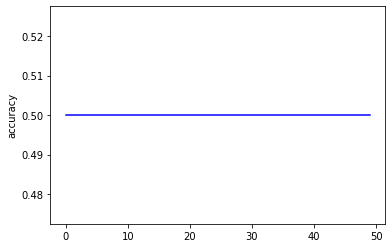

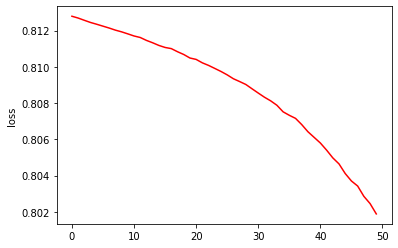

tf.Tensor(
[[0.28876415 0.71123594]
 [0.28876415 0.71123594]
 [0.276356   0.723644  ]
 [0.28192133 0.7180787 ]
 [0.27187255 0.7281275 ]
 [0.27187255 0.7281275 ]
 [0.28490922 0.71509075]
 [0.28192133 0.7180787 ]], shape=(8, 2), dtype=float32)
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 11, 6)]      0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           [(None, 11, 6)]      0                                            
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 8)            356         input_25[0][0]                   
                                               

In [73]:
plt.plot(history.history['accuracy'], 'b')
plt.ylabel('accuracy')
plt.show()

plt.plot(history.history['loss'], 'r')
plt.ylabel('loss')
plt.show()

print(conjoined_net((x1, x2)))
conjoined_net.summary()